### CS 216 Project
##### Cameron Jarnot (cmj36), Delaney Demark (dad48), Joseph Scarpa (jcs140), Sharan Sokhi (ss1148)

## Add to this "full" notebook after implementing in a sub-notebook

In [ ]:
# Imports (update throughout as necessary)
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt # just to format confusion matrix

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

import re

import scipy
from scipy import stats

#### Data loading and cleaning

Notes:
* No null values found
* No duplicate values found

In [ ]:
# Data loading
data10 = pd.read_csv('./datasets/dataset-of-10s.csv')
data00 = pd.read_csv('./datasets/dataset-of-00s.csv')
data90 = pd.read_csv('./datasets/dataset-of-90s.csv')
data80 = pd.read_csv('./datasets/dataset-of-80s.csv')
data70 = pd.read_csv('./datasets/dataset-of-70s.csv')
data60 = pd.read_csv('./datasets/dataset-of-60s.csv')

In [ ]:
# Data cleaning

# Drop all na values
data10 = data10.dropna()
data00 = data00.dropna()
data90 = data90.dropna()
data80 = data80.dropna()
data70 = data70.dropna()
data60 = data60.dropna()


# Add a decades column to each dataset (will be helpful when creating cumulative dataset)
data10['decade'] = [2010]*len(data10)
data00['decade'] = [2000]*len(data00)
data90['decade'] = [1990]*len(data90)
data80['decade'] = [1980]*len(data80)
data70['decade'] = [1970]*len(data70)
data60['decade'] = [1960]*len(data60)


In [ ]:
# Check for duplicates in dataset
merged = data10.merge(data00,on=['track','artist'])
merged = merged.merge(data90,on=['track','artist'])
merged = merged.merge(data80,on=['track','artist'])
merged = merged.merge(data70,on=['track','artist'])
merged = merged.merge(data60,on=['track','artist'])
merged
# NOTE: No duplicates found

,uri_x,danceability_x,energy_x,key_x,loudness_x,mode_x,speechiness_x,acousticness_x,instrumentalness_x,liveness_x,...,instrumentalness_y,liveness_y,valence_y,tempo_y,duration_ms_y,time_signature_y,chorus_hit_y,sections_y,target_y,decade_y


In [ ]:
# Create cumulative dataset (from songs across all decades)
data = data10.append(data00,ignore_index=True).append(data90,ignore_index=True).append(data80,ignore_index=True).append(data70,ignore_index=True).append(data60,ignore_index=True)
data.head()
data.tail()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
41101,Le ire di Ursus,Giampiero Boneschi,spotify:track:3dVgolCVuNgecU5jovpc45,0.420,0.8730,3,-11.689,1,0.1000,0.808,0.879000,0.363,0.183,119.821,26244,4,0.00000,2,0,1960
41102,A-B-C,John Zacherle,spotify:track:0zXhzKf4raEYstebL7L42C,0.716,0.7420,10,-5.727,0,0.2420,0.663,0.000000,0.107,0.834,135.104,142987,4,28.34316,10,0,1960
41103,Useless Landscape,Antônio Carlos Jobim,spotify:track:2uC02PCRVM6BhAaK7dgxxp,0.361,0.0944,10,-22.663,1,0.0327,0.940,0.000178,0.115,0.139,92.472,137200,4,56.63498,6,0,1960
41104,Vendedor De Assaí,Ary Lobo,spotify:track:0gpSUWZWNIRrEenaC1ZGk9,0.452,0.7590,4,-7.821,0,0.1750,0.658,0.000000,0.738,0.853,137.976,159107,3,28.24372,9,0,1960
41105,Mambo Simphony - Remasterizado,Orquesta Casino De La Playa,spotify:track:5j0G0nkCSPlmSCSgXchMn3,0.554,0.2780,5,-8.386,1,0.0349,0.928,0.922000,0.136,0.428,131.401,164227,4,37.39251,8,0,1960


In [ ]:
# Add custom columns that will be useful later

# Duration of song in seconds
data["duration_sec"] = np.round(data["duration_ms"]*(1/1000))
data["duration_sec"]

# Loudness of sound (rounded)
data["loudness_rounded"] = np.round(data["loudness"])
data["loudness_rounded"]

0        -5.0
1       -15.0
2        -7.0
3        -6.0
4        -4.0
         ... 
41101   -12.0
41102    -6.0
41103   -23.0
41104    -8.0
41105    -8.0
Name: loudness_rounded, Length: 41106, dtype: float64

#### General statistics
Means, medians, modes, standard deviations of each column for both unique decades and the overall dataset

In [ ]:
# General stats (means, medians, standard deviations, etc) for each column (decades and overall)

# Number of rows and columns
num_rows = len(data.index)
num_columns = len(data.columns)

# Loudness Stats
loudness_stats = data.groupby('decade')['loudness'].describe().reset_index()
max_loudness_record = data[data["loudness"] == loudness_stats["max"].max()]
min_loudness_record = data[data["loudness"] == loudness_stats["max"].min()]

# Energy Stats
energy_stats = data.groupby('decade')['energy'].describe().reset_index()
max_energy_record = data[data["energy"] == energy_stats["max"].max()]
min_energy_record = data[data["energy"] == energy_stats["min"].min()]

# Speachiness Stats
speechiness_stats = data.groupby('decade')['speechiness'].describe().reset_index()
max_speechiness_record = data[data["speechiness"] == energy_stats["max"].max()]
min_speechiness_record = data[data["speechiness"] == energy_stats["min"].min()]

# Danceability Stats
danceability_stats = data.groupby('decade')['danceability'].describe().reset_index()
max_danceability_record = data[data["danceability"] == energy_stats["max"].max()]
min_danceability_record = data[data["danceability"] == energy_stats["min"].max()]

# Valence Stats
valence_stats = data.groupby('decade')['valence'].describe().reset_index()
max_valence_record = data[data["valence"] == energy_stats["max"].max()]
min_valence_record = data[data["valence"] == energy_stats["min"].min()]

# Tempo Stats
tempo_stats = data.groupby('decade')['tempo'].describe().reset_index()
max_tempo_record = data[data["tempo"] == energy_stats["max"].max()]
min_tempo_record = data[data["tempo"] == energy_stats["min"].min()]

# Instrumentalness Stats
instrumentalness_stats = data.groupby('decade')['instrumentalness'].describe().reset_index()
max_instrumentalness_record = data[data["instrumentalness"] == energy_stats["max"].max()]
min_instrumentalness_record = data[data["instrumentalness"] == energy_stats["min"].min()]

# Duration Stats
duration_stats = data.groupby('decade')['duration_sec'].describe().reset_index()
max_duration_record = data[data["duration_sec"] == energy_stats["max"].max()]
min_duration_record = data[data["duration_sec"] == energy_stats["min"].min()]

# Proportion of songs that are a hit
proportion_hits = data.groupby('decade')['target'].mean()

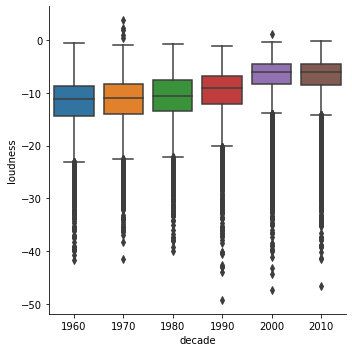

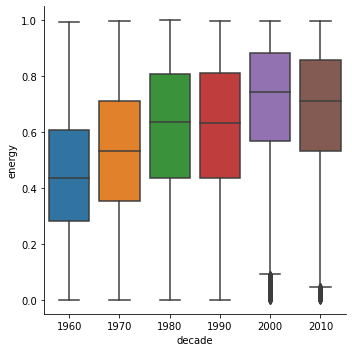

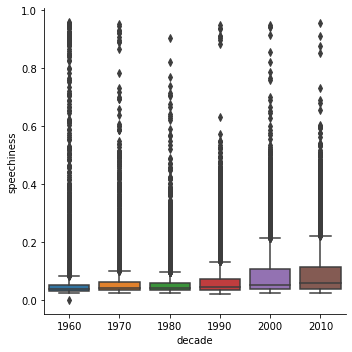

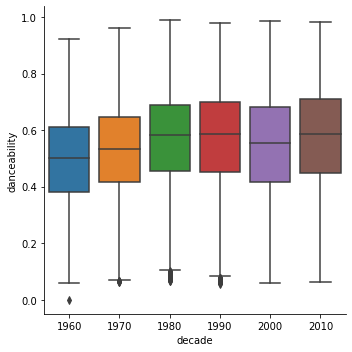

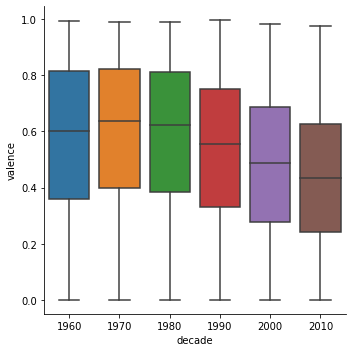

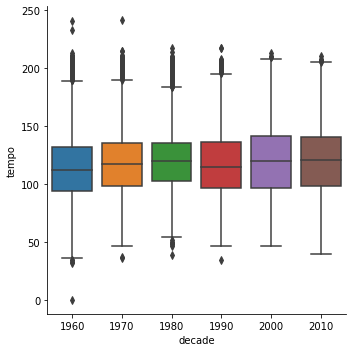

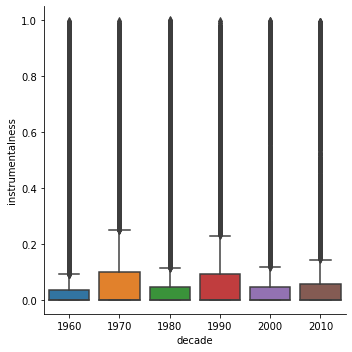

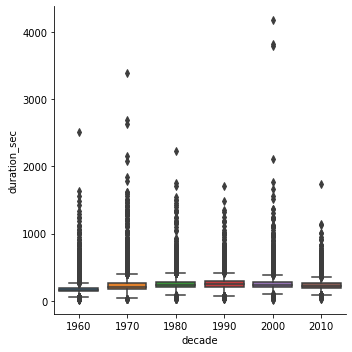

In [ ]:
# Add plots with data from basic analysis of data (decades and overall)

# loudness over time (Box plot)
sns.catplot(x="decade", y="loudness", data=data, kind="box")

# energy over time (Box plot)
sns.catplot(x="decade", y="energy", data=data, kind="box")

# speechiness over time (Box Plot)
sns.catplot(x="decade", y="speechiness", data=data, kind="box")

# danceability over time (Box Plot)
sns.catplot(x="decade", y="danceability", data=data, kind="box")

# valence over time (Box Plot)
sns.catplot(x="decade", y="valence", data=data, kind="box")

# tempo over time (Box Plot)
sns.catplot(x="decade", y="tempo", data=data, kind="box")

# instrumental stats over time (Box Plot)
sns.catplot(x="decade", y="instrumentalness", data=data, kind="box")

# duration over time (Box Plot)
sns.catplot(x="decade", y="duration_sec", data=data, kind="box")

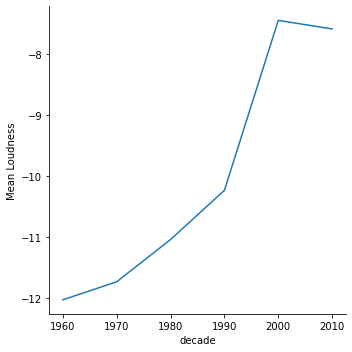

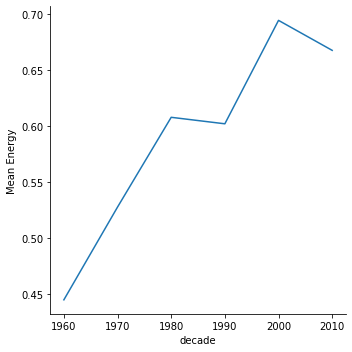

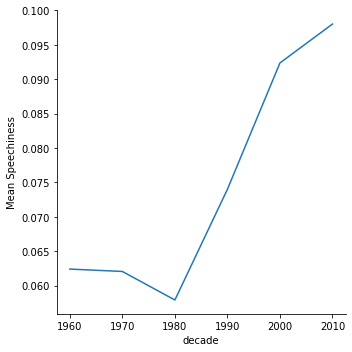

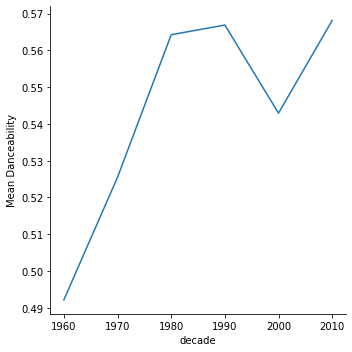

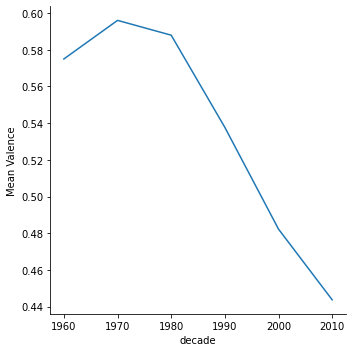

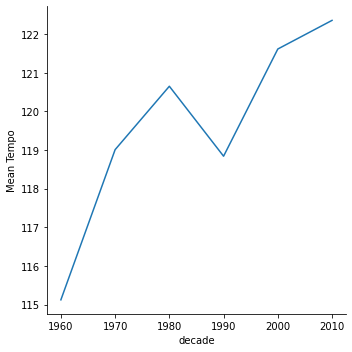

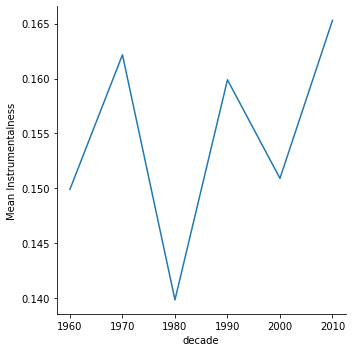

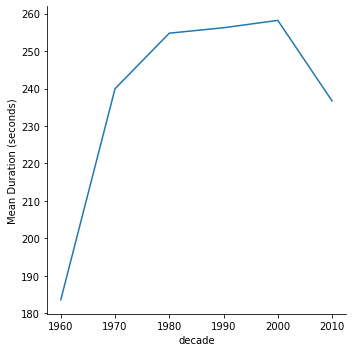

In [ ]:
# Add plots with data from basic analysis of data (decades and overall)

# mean loudness over time (Line Plot)
sns.relplot(x="decade", y="mean", kind="line", data = loudness_stats).set(ylabel="Mean Loudness")

# mean energy over time (Line Plot)
sns.relplot(x="decade", y="mean", kind="line", data = energy_stats).set(ylabel="Mean Energy")

# mean speechiness over time (Line Plot)
sns.relplot(x="decade", y="mean", kind="line", data = speechiness_stats).set(ylabel="Mean Speechiness")

# mean danceability over time (Line Plot)
sns.relplot(x="decade", y="mean", kind="line", data = danceability_stats).set(ylabel="Mean Danceability")

# mean valence over time (Line Plot)
sns.relplot(x="decade", y="mean", kind="line", data = valence_stats).set(ylabel="Mean Valence")

# mean tempo over time (Line Plot)
sns.relplot(x="decade", y="mean", kind="line", data = tempo_stats).set(ylabel="Mean Tempo")

# mean instrumental over time (Line Plot)
sns.relplot(x="decade", y="mean", kind="line", data = instrumentalness_stats).set(ylabel="Mean Instrumentalness")

# mean duration over (Line Plot)
sns.relplot(x="decade", y="mean", kind="line", data = duration_stats).set(ylabel="Mean Duration (seconds)")


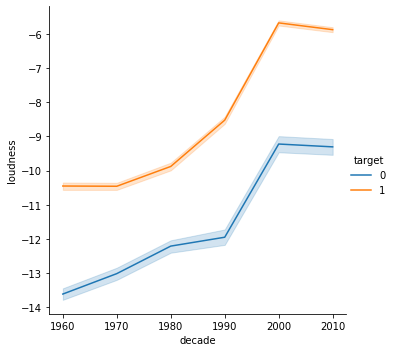

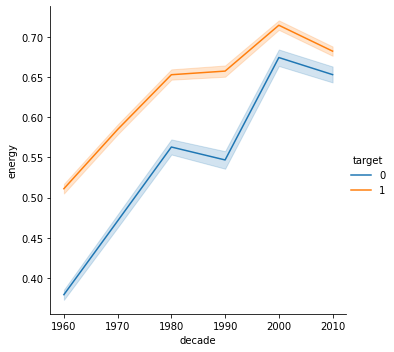

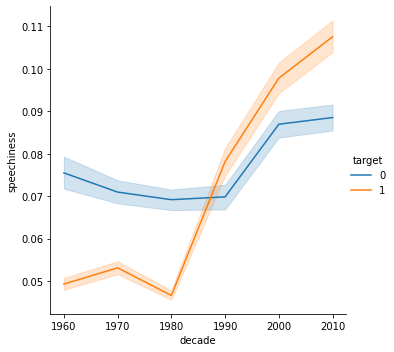

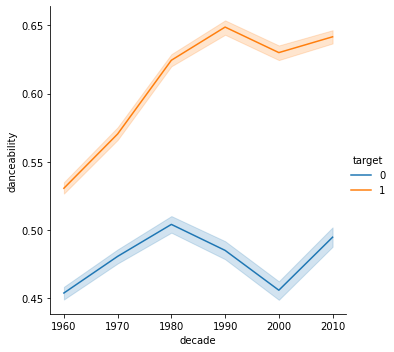

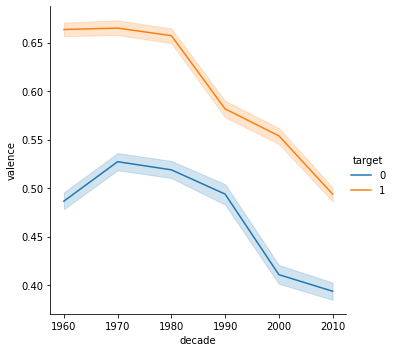

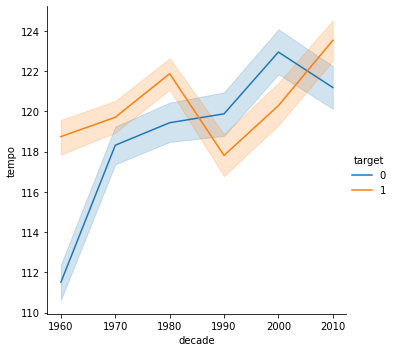

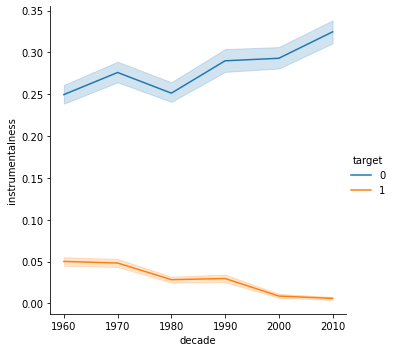

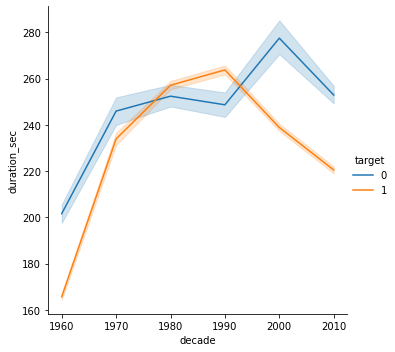

In [ ]:
# Add plots with data from basic analysis of data (decades and overall)

# loudness vs target (Line Plot)
sns.relplot(x="decade", y="loudness", hue="target", kind="line", data = data)

# energy vs target (Line Plot)
sns.relplot(x="decade", y="energy", hue="target", kind="line", data = data)

# speechiness vs target (Line Plot)
sns.relplot(x="decade", y="speechiness", hue="target", kind="line", data = data)

# speechiness vs target (Line Plot)
sns.relplot(x="decade", y="danceability", hue="target", kind="line", data = data)

# valence vs target (Line Plot)
sns.relplot(x="decade", y="valence", hue="target", kind="line", data = data)

# tempo vs target (Line Plot)
sns.relplot(x="decade", y="tempo", hue="target", kind="line", data = data)

# instrumental vs target (Line Plot)
sns.relplot(x="decade", y="instrumentalness", hue="target", kind="line", data = data)

# duration over time (Line Plot)
sns.relplot(x="decade", y="duration_sec", hue="target", kind="line", data = data)


#### Decade by decade statistical analysis
Analysis of relationships between each column and 'hits' vs 'flops' for each decade

Notes:
* Results are stored in dataframe named "decade_by_decade"

In [ ]:
# Target proportion versus duration in seconds.
decades = [data60,data70,data80,data90,data00,data10]
years = ['1960','1970','1980','1990','2000','2010']

durations:
[    ds_int duration_sec      mean  count
0       10     (10, 20]  0.000000      3
1       20     (20, 30]  0.000000     14
2       30     (30, 40]  0.000000     23
3       40     (40, 50]  0.027027     37
4       50     (50, 60]  0.000000     50
..     ...          ...       ...    ...
77     780   (780, 790]  0.000000      1
80     790   (810, 820]  0.000000      1
81     800   (820, 830]  0.000000      1
82     810   (830, 840]  0.000000      1
83     820   (840, 850]  0.000000      1

[82 rows x 4 columns],     ds_int duration_sec      mean  count
0       10     (10, 20]  0.333333      3
1       20     (20, 30]  0.666667     12
2       30     (30, 40]  0.476190     21
3       40     (40, 50]  0.387097     31
4       50     (50, 60]  0.478261     46
..     ...          ...       ...    ...
80     780   (810, 820]  1.000000      1
81     790   (820, 830]  1.000000      1
82     800   (830, 840]  1.000000      1
83     810   (840, 850]  1.000000      1
84     820   (850, 86

Text(0.5, 1.0, 'Duration Resulting in Highest Proportion Hits Across Decades 1960-2010')

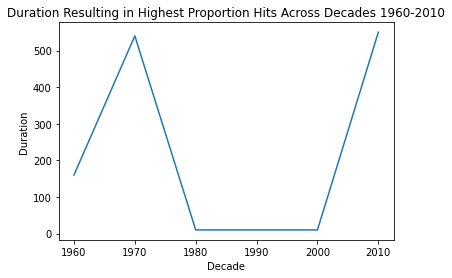

In [ ]:
# Decade by decade stat analysis (relationships between each decade and each column)
# Cameron
durations = []
for decade in [data60,data70,data80,data90,data00,data10]:
    decade['duration_sec'] = data60['duration_ms']//1000
    relevant = decade['duration_sec']
    bin_max = decade["duration_sec"].max()
    i = 1
    bin_arr = []
    while i * 10 < bin_max+10:
        bin_arr.append(i*10)
        i+=1
    bins = pd.cut(decade['duration_sec'], bin_arr)
    hitsDuration = decade.groupby(bins)['target'].agg(["mean", "count"]).reset_index().dropna()

    hitsDurationSliced = hitsDuration[:82]
    hitsDurationSliced.insert(0, 'ds_int', range(1, 1+ len(hitsDurationSliced)))
    hitsDurationSliced["ds_int"] = hitsDurationSliced["ds_int"] *10
    durations += [hitsDurationSliced]
    # print(durations)
maxDurs = []
print('durations:')
print(durations)
for dur in durations:
    maxDurs += [dur['ds_int'][dur['mean'].idxmax()]]
# print(maxDurs)
plt.plot(years,maxDurs)
plt.xlabel('Decade')
plt.ylabel('Duration')
plt.title('Duration Resulting in Highest Proportion Hits Across Decades 1960-2010')

# decades = [data60,data70,data80,data90,data00,data10]
# decs = ['60','70','80','90','00','10']
# sigDurationDiff = []
# durationMeans = []
# for dec1 in range(len(decades)):
#     dec1M = dec1['duration_sec'].mean()
#     std1 = dec1['duration_sec'].std()
#     durationMeans += [dec1M]
#     for dec2 in decades:
#         dec2M = dec2['duration_sec'].mean()
#         std2 = dec2['duration_sec'].std()
#         p = scipy.stats.ttest_ind_from_stats(dec1M,std1,len(dec1),dec2M,std2,len(dec2))[1]
#         if p <= 0.05 and [dec2['decade'][0],dec1['decade'][0]] not in sigDurationDiff:
#             sigDurationDiff += [dec1['decade'][0],dec2['decade'][0]]

Text(0.5, 1.0, 'Loudness Resulting in Highest Proportion Hits Across Decades 1960-2010')

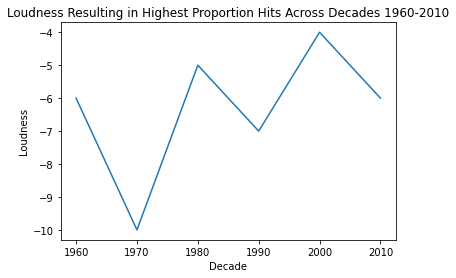

In [ ]:
louds = []
for decade in [data60,data70,data80,data90,data00,data10]:
    decade['loudness_rounded'] = round(decade['loudness'])
    hitsLoudness = decade.groupby("loudness_rounded")['target'].agg(["mean", "count"]).reset_index().dropna()
    hitsLoudness = hitsLoudness.loc[hitsLoudness['count'] > 10]
    louds += [hitsLoudness]
maxLoud = []
for dur in louds:
    maxLoud += [dur['loudness_rounded'][dur['mean'].idxmax()]]
plt.plot(years,maxLoud)
plt.xlabel('Decade')
plt.ylabel('Loudness')
plt.title('Loudness Resulting in Highest Proportion Hits Across Decades 1960-2010')

Text(0.5, 1.0, 'Energy Resulting in Highest Proportion Hits Across Decades 1960-2010')

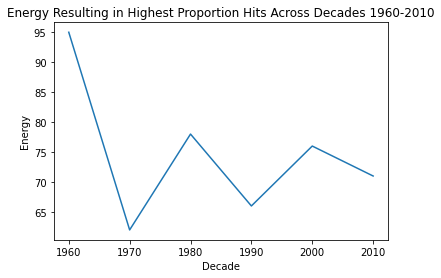

In [ ]:
energies = []
for decade in [data60,data70,data80,data90,data00,data10]:
    i = 0
    bin_arr_energy = []
    while i <= 100:
        bin_arr_energy.append(i/100)
        i+=1
    bins_energy = pd.cut(decade['energy'], bin_arr_energy)
    hitsEnergy = decade.groupby(bins_energy)['target'].agg(["mean", "count"]).reset_index().dropna()
    hitsEnergy.insert(0, 'en_int', range(0, 100))
    hitsEnergy["en_int"] = hitsEnergy["en_int"] / 100
    energies += [hitsEnergy]
maxEnergies = []
for en in energies:
    maxEnergies += [en['mean'].idxmax()]
# print(maxEnergies)
plt.plot(years,maxEnergies)
plt.xlabel('Decade')
plt.ylabel('Energy')
plt.title('Energy Resulting in Highest Proportion Hits Across Decades 1960-2010')

Text(0.5, 1.0, 'Danceability Resulting in Highest Proportion Hits Across Decades 1960-2010')

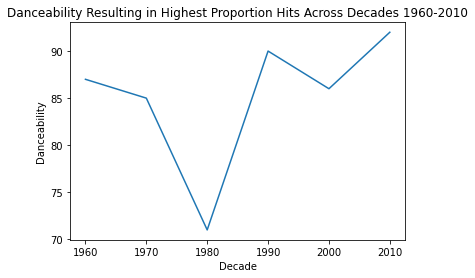

In [ ]:
dances = []
for decade in [data60,data70,data80,data90,data00,data10]:
    # print(decade)
    i = 5
    bin_arr_danceability = []
    while i <= 98:
        bin_arr_danceability.append(i/100)
        i+=1

    bins_danceability = pd.cut(decade['danceability'], bin_arr_danceability)
    target_prop_by_danceability = decade.groupby(bins_danceability)['target'].agg(["mean", "count"]).reset_index().dropna()

    minDance = decade['danceability'].min()*100
    maxDance = decade['danceability'].max()*100
    target_prop_by_danceability.insert(0, 'da_int', decade['danceability']*100)
    target_prop_by_danceability['da_int'] = target_prop_by_danceability['da_int']/100

    dances += [target_prop_by_danceability]
maxDances = []
for dan in dances:
    maxDances += [dan['mean'].idxmax()]
plt.plot(years,maxDances)
plt.xlabel('Decade')
plt.ylabel('Danceability')
plt.title('Danceability Resulting in Highest Proportion Hits Across Decades 1960-2010')

Text(0.5, 1.0, 'Valence Resulting in Highest Proportion Hits Across Decades 1960-2010')

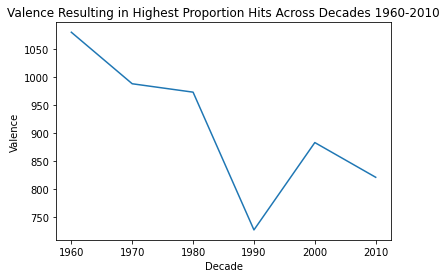

In [ ]:
vals = []
for decade in [data60,data70,data80,data90,data00,data10]:
    target_prop_by_valence = decade.groupby("valence")['target'].agg(["mean", "count"]).reset_index().dropna()
    target_prop_by_valence = target_prop_by_valence.loc[target_prop_by_valence['count'] > 10]
    vals += [target_prop_by_valence]
maxVals = []
for val in vals:
    maxVals += [val['mean'].idxmax()]
plt.plot(years,maxVals)
plt.xlabel('Decade')
plt.ylabel('Valence')
plt.title('Valence Resulting in Highest Proportion Hits Across Decades 1960-2010')

Text(0.5, 1.0, 'Mode Resulting in Highest Proportion Hits Across Decades 1960-2010')

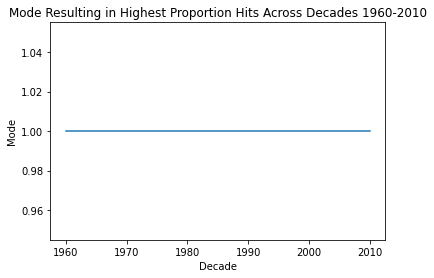

In [ ]:
modes = []
for decade in [data60,data70,data80,data90,data00,data10]:
    target_prop_by_mode = data.groupby("mode")['target'].agg(["mean", "count"]).reset_index().dropna()
    modes += [target_prop_by_mode]
maxModes = []
for mode in modes:
    maxModes += [mode['mean'].idxmax()]
plt.plot(years,maxModes)
plt.xlabel('Decade')
plt.ylabel('Mode')
plt.title('Mode Resulting in Highest Proportion Hits Across Decades 1960-2010')

Text(0.5, 1.0, 'Time Signature Resulting in Highest Proportion Hits Across Decades 1960-2010')

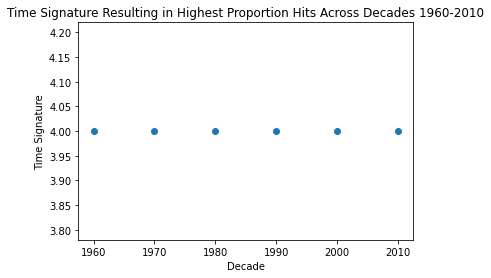

In [ ]:
timeSigs = []
for decade in [data60,data70,data80,data90,data00,data10]:
    target_prop_by_time_signature = data.groupby("time_signature")['target'].agg(["count"]).sort_values(by='count',ascending=False).reset_index().dropna()
    timeSigs += [target_prop_by_time_signature.loc[0,'time_signature']]
plt.scatter(years,timeSigs)
plt.xlabel('Decade')
plt.ylabel('Time Signature')
plt.title('Time Signature Resulting in Highest Proportion Hits Across Decades 1960-2010')

In [ ]:
# Add plots with data from decade by decade stat analysis
# Cameron

# Plot maximum hit proportion for each variable across the decades

# pd.crosstab(data['decade'],data['target']).plot.bar(stacked = True)""

#### Hypothesis testing for difference in values with highest proportion in each data set

In [ ]:
# Duration
sigDurationDiff = []
durationMeans = []
for dec1 in decades:
    dec1M = dec1['duration_sec'].mean()
    std1 = dec1['duration_sec'].std()
    durationMeans += [dec1M]
    for dec2 in decades:
        dec2M = dec2['duration_sec'].mean()
        std2 = dec2['duration_sec'].std()
        p = scipy.stats.ttest_ind_from_stats(dec1M,std1,len(dec1),dec2M,std2,len(dec2))[1]
        if p <= 0.05 and [dec2['decade'][0],dec1['decade'][0]] not in sigDurationDiff:
            sigDurationDiff += [dec1['decade'][0],dec2['decade'][0]]

# Loudness
sigLoudDiff = []
loudMeans = []
for dec1 in decades:
    dec1M = dec1['loudness_rounded'].mean()
    std1 = dec1['loudness_rounded'].std()
    loudMeans += [dec1M]
    for dec2 in decades:
        dec2M = dec2['loudness_rounded'].mean()
        std2 = dec2['loudness_rounded'].std()
        p = scipy.stats.ttest_ind_from_stats(dec1M,std1,len(dec1),dec2M,std2,len(dec2))[1]
        if p <= 0.05 and [dec2['decade'][0],dec1['decade'][0]] not in sigLoudDiff:
            sigLoudDiff += [[dec1['decade'][0],dec2['decade'][0]]]

# Energy
sigEnergyDiff = []
energyMeans = []
for dec1 in decades:
    dec1M = dec1['energy'].mean()
    std1 = dec1['energy'].std()
    energyMeans += [dec1M]
    for dec2 in decades:
        dec2M = dec2['energy'].mean()
        std2 = dec2['energy'].std()
        p = scipy.stats.ttest_ind_from_stats(dec1M,std1,len(dec1),dec2M,std2,len(dec2))[1]
        if p <= 0.05 and [dec2['decade'][0],dec1['decade'][0]] not in sigEnergyDiff:
            sigEnergyDiff += [[dec1['decade'][0],dec2['decade'][0]]]

# Danceability
sigDanceDiff = []
danceMeans = []
for dec1 in decades:
    dec1M = dec1['danceability'].mean()
    std1 = dec1['danceability'].std()
    danceMeans += [dec1M]
    for dec2 in decades:
        dec2M = dec2['danceability'].mean()
        std2 = dec2['danceability'].std()
        p = scipy.stats.ttest_ind_from_stats(dec1M,std1,len(dec1),dec2M,std2,len(dec2))[1]
        if p <= 0.05 and [[dec2['decade'][0]],dec1['decade'][0]] not in sigDanceDiff:
            sigDanceDiff += [[dec1['decade'][0],dec2['decade'][0]]]

# Valence
sigValDiff = []
valMeans = []
for dec1 in decades:
    dec1M = dec1['valence'].mean()
    std1 = dec1['valence'].std()
    valMeans += [dec1M]
    for dec2 in decades:
        dec2M = dec2['valence'].mean()
        std2 = dec2['valence'].std()
        p = scipy.stats.ttest_ind_from_stats(dec1M,std1,len(dec1),dec2M,std2,len(dec2))[1]
        if p <= 0.05 and [dec2['decade'][0],dec1['decade'][0]] not in sigValDiff:
            sigValDiff += [[dec1['decade'][0],dec2['decade'][0]]]

# Mode
sigModeDiff = []
modeMeans = []
for dec1 in decades:
    dec1M = dec1['mode'].mean()
    std1 = dec1['mode'].std()
    modeMeans += [dec1M]
    for dec2 in decades:
        dec2M = dec2['mode'].mean()
        std2 = dec2['mode'].std()
        p = scipy.stats.ttest_ind_from_stats(dec1M,std1,len(dec1),dec2M,std2,len(dec2))[1]
        if p <= 0.05 and [[dec2['decade'][0]],dec1['decade'][0]] not in sigModeDiff:
            sigModeDiff += [[dec1['decade'][0],dec2['decade'][0]]]

# Time signature
sigTimeDiff = []
timeMeans = []
for dec1 in decades:
    dec1M = dec1['time_signature'].mean()
    std1 = dec1['time_signature'].std()
    timeMeans += [dec1M]
    for dec2 in decades:
        dec2M = dec2['time_signature'].mean()
        std2 = dec2['time_signature'].std()
        p = scipy.stats.ttest_ind_from_stats(dec1M,std1,len(dec1),dec2M,std2,len(dec2))[1]
        if p <= 0.05 and [[dec2['decade'][0]],dec1['decade'][0]] not in sigTimeDiff:
            sigTimeDiff += [[dec1['decade'][0],dec2['decade'][0]]]

print('Duration: ',sigDurationDiff)
print('Duration means: ',durationMeans)
print('')
print('Loudness: ',sigLoudDiff)
print('Loudness means: ',loudMeans)
print('')
print('Energy: ',sigEnergyDiff)
print('Energy means: ',energyMeans)
print('')
print('Danceability: ',sigDanceDiff)
print('Danceability means: ',danceMeans)
print('')
print('Valence: ',sigValDiff)
print('Valence means: ',valMeans)
print('')
print('Mode: ',sigModeDiff)
print('Mode means: ',modeMeans)
print('')
print('Time signature: ',sigTimeDiff)
print('Time signature means: ',timeMeans)

Duration:  []
Duration means:  [183.15621383938904, 183.5797064125676, 183.88100752750435, 184.12373188405797, 184.25647138964578, 183.7607064707721]

Loudness:  [[1960, 1970], [1960, 1980], [1960, 1990], [1960, 2000], [1960, 2010], [1970, 1980], [1970, 1990], [1970, 2000], [1970, 2010], [1980, 1990], [1980, 2000], [1980, 2010], [1990, 2000], [1990, 2010]]
Loudness means:  [-12.02904420273085, -11.733968580994077, -11.037782281412854, -10.236050724637682, -7.450442779291553, -7.59002813379181]

Energy:  [[1960, 1970], [1960, 1980], [1960, 1990], [1960, 2000], [1960, 2010], [1970, 1980], [1970, 1990], [1970, 2000], [1970, 2010], [1980, 2000], [1980, 2010], [1990, 2000], [1990, 2010], [2000, 2010]]
Energy means:  [0.44520961513538526, 0.5279522637136235, 0.6080370477707007, 0.6022463936594203, 0.6945108549046322, 0.6677564696780244]

Danceability:  [[1960, 1970], [1960, 1980], [1960, 1990], [1960, 2000], [1960, 2010], [1970, 1980], [1970, 1990], [1970, 2000], [1970, 2010], [1980, 2000], 

#### Cumulative statistical analysis
Analysis of relationships between each column and 'hits' vs 'flops' for all decades overall

Notes:
* Results are stored in dataframe named "overall_stats"

#### Overall stat analysis (relationships between cumulative decades and each column) - data
##### Joey Scarpa


In [ ]:
# Target proportion versus duration in seconds.
bin_max = data["duration_sec"].max()
print(bin_max)
i = 1
bin_arr = []
while i * 10 < bin_max+10:
    bin_arr.append(i*10)
    i+=1
print(bin_arr)
bins = pd.cut(data['duration_sec'], bin_arr )
target_prop_by_duration = data.groupby(bins)['target'].agg(["mean", "count"]).reset_index().dropna()
#target_prop_by_duration

target_prop_by_duration_sliced = target_prop_by_duration[:82]
target_prop_by_duration_sliced.insert(0, 'ds_int', range(1, 1+ len(target_prop_by_duration_sliced)))
target_prop_by_duration_sliced["ds_int"] = target_prop_by_duration_sliced["ds_int"] *10
target_prop_by_duration_sliced

4170.0
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 18

,ds_int,duration_sec,mean,count
0,10,"(10, 20]",0.000000,5
1,20,"(20, 30]",0.000000,30
2,30,"(30, 40]",0.000000,63
3,40,"(40, 50]",0.012500,80
4,50,"(50, 60]",0.008850,113
...,...,...,...,...
77,780,"(780, 790]",0.000000,7
78,790,"(790, 800]",0.000000,5
79,800,"(800, 810]",0.000000,3
80,810,"(810, 820]",0.000000,7


In [ ]:
#Target proportion vs energy
i = 0
bin_arr_energy = []
while i <= 100:
    bin_arr_energy.append(i/100)
    i+=1
print(bin_arr_energy)
bins_energy = pd.cut(data['energy'], bin_arr_energy)
target_prop_by_energy = data.groupby(bins_energy)['target'].agg(["mean", "count"]).reset_index().dropna()
#target_prop_by_energy = target_prop_by_energy.loc[target_prop_by_energy['count'] > 10]
target_prop_by_energy.insert(0, 'en_int', range(0, 100))
target_prop_by_energy["en_int"] = target_prop_by_energy["en_int"] / 100
target_prop_by_energy


[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]


,en_int,energy,mean,count
0,0.00,"(0.0, 0.01]",0.000000,202
1,0.01,"(0.01, 0.02]",0.007937,126
2,0.02,"(0.02, 0.03]",0.067485,163
3,0.03,"(0.03, 0.04]",0.025316,158
4,0.04,"(0.04, 0.05]",0.034091,176
...,...,...,...,...
95,0.95,"(0.95, 0.96]",0.321101,436
96,0.96,"(0.96, 0.97]",0.207921,404
97,0.97,"(0.97, 0.98]",0.210660,394
98,0.98,"(0.98, 0.99]",0.113580,405


In [ ]:
#Target proportion vs dancibility

i = 5
bin_arr_danceability = []
while i <= 98:
    bin_arr_danceability.append(i/100)
    i+=1

bins_danceability = pd.cut(data['danceability'], bin_arr_danceability)
target_prop_by_danceability = data.groupby(bins_danceability)['target'].agg(["mean", "count"]).reset_index().dropna()

target_prop_by_danceability.insert(0, 'da_int', range(5, 98)) # This line
target_prop_by_danceability["da_int"] = target_prop_by_danceability["da_int"] / 100

target_prop_by_danceability


,da_int,danceability,mean,count
0,0.05,"(0.05, 0.06]",0.000000,7
1,0.06,"(0.06, 0.07]",0.000000,40
2,0.07,"(0.07, 0.08]",0.000000,53
3,0.08,"(0.08, 0.09]",0.000000,58
4,0.09,"(0.09, 0.1]",0.014706,68
...,...,...,...,...
88,0.93,"(0.93, 0.94]",0.825397,63
89,0.94,"(0.94, 0.95]",0.755556,45
90,0.95,"(0.95, 0.96]",0.772727,22
91,0.96,"(0.96, 0.97]",0.789474,19


In [ ]:
#Target proportion vs dancibility
target_prop_by_loudness = data.groupby("loudness_rounded")['target'].agg(["mean", "count"]).reset_index().dropna()
target_prop_by_loudness = target_prop_by_loudness.loc[target_prop_by_loudness['count'] > 10]


target_prop_by_loudness



,loudness_rounded,mean,count
6,-40.0,0.000000,11
7,-39.0,0.000000,13
8,-38.0,0.000000,11
9,-37.0,0.000000,15
10,-36.0,0.000000,19
11,-35.0,0.000000,20
12,-34.0,0.000000,28
13,-33.0,0.000000,33
14,-32.0,0.000000,42
15,-31.0,0.000000,59


In [ ]:
#Target proportion vs valence
target_prop_by_valence = data.groupby("valence")['target'].agg(["mean", "count"]).reset_index().dropna()
target_prop_by_valence = target_prop_by_valence.loc[target_prop_by_valence['count'] > 10]

target_prop_by_valence


,valence,mean,count
0,0.0000,0.071429,14
117,0.0350,0.000000,11
118,0.0351,0.000000,12
125,0.0358,0.000000,14
129,0.0362,0.000000,14
...,...,...,...
1593,0.9760,0.608696,23
1594,0.9770,0.578947,19
1595,0.9780,0.533333,15
1596,0.9790,0.750000,12


In [ ]:
#Target proportion vs mode
target_prop_by_mode = data.groupby("mode")['target'].agg(["mean", "count"]).reset_index().dropna()

target_prop_by_mode

,mode,mean,count
0,0,0.440143,12605
1,1,0.526473,28501


In [ ]:
#Target proportion vs time signature
target_prop_by_time_signature = data.groupby("time_signature")['target'].agg(["mean", "count"]).reset_index().dropna()

target_prop_by_time_signature

,time_signature,mean,count
0,0,0.333333,3
1,1,0.191375,371
2,3,0.309896,3840
3,4,0.527785,36297
4,5,0.225210,595


#### Add plots with data from overall stat analysis - data
##### Joey Scarpa


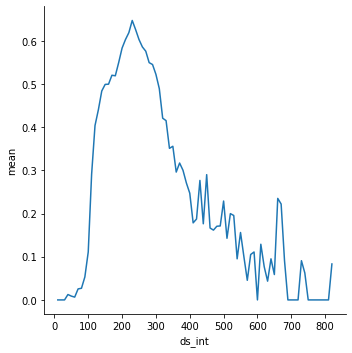

In [ ]:
# Proportion of hits versus duration in seconds represented as a bar chart. 
#sns.catplot(x = "ds_int", y = "mean", kind = "bar", data = target_prop_by_duration_sliced)
sns.relplot(x = "ds_int", y = "mean", data = target_prop_by_duration_sliced, kind = "line")
#sns.displot(data = target_prop_by_duration_sliced, x = "ds_int", y = "mean", cbar = True)


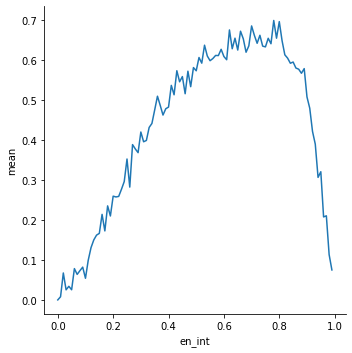

In [ ]:
# Energy vs hits
sns.relplot(x = "en_int", y = "mean", kind = "line", data = target_prop_by_energy)


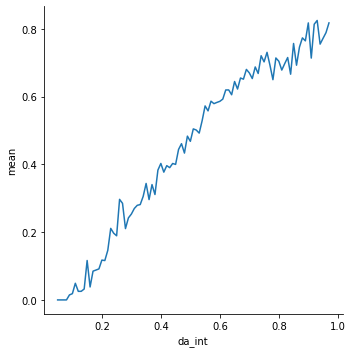

In [ ]:
# Dancebility vs hits
sns.relplot(x = "da_int", y = "mean",  kind = "line", data = target_prop_by_danceability)


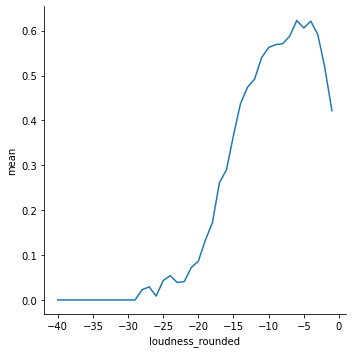

In [ ]:
# Loudness vs hits
sns.relplot(x = "loudness_rounded", y = "mean", kind = "line", data = target_prop_by_loudness)


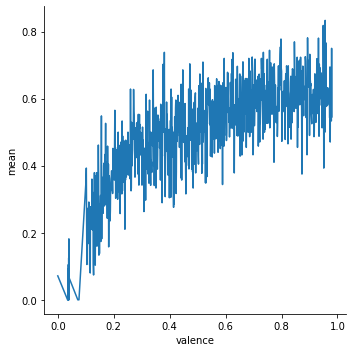

In [ ]:
# Valence vs hits
sns.relplot(x = "valence", y = "mean",  kind = "line", data = target_prop_by_valence)


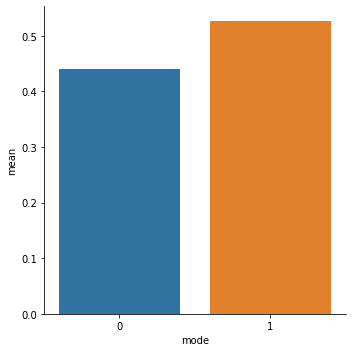

In [ ]:
# Mode vs hits

# Good question to do hypothesis test on. 
sns.catplot(x = "mode", y = "mean",  kind = "bar", data = target_prop_by_mode)


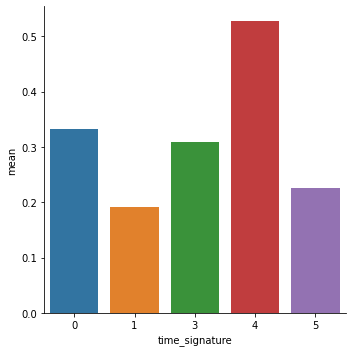

In [ ]:
# Time signature vs hits

# Good question to do hypothesis test on. 
sns.catplot(x = "time_signature", y = "mean", kind = "bar", data = target_prop_by_time_signature)


To do

In [ ]:
# Linear regression of trends in factors making a hit across each decade (maybe one per column?)
# Brainstorm - Tackle on the 24th October


# Hypothesis tests for changes across decades
# Brainstorm - Tackle on the 24th October

# Hypothesis Test:
# Mean loudness of hit - Mean loudness of flop = a constant?

# Linear regression of trends - e.g. loudness & decades for both hits and flops

In [ ]:
#Joey
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3)
#X is 2d array of samples and features
propColData = data[['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence']].to_numpy()
propColData
#Y is hit vs flop. .
targetData = data['target'].to_numpy()
targetData
#Fit the model
sfs.fit(propColData, targetData)
sfs.get_support()
'''Indicates that danceability, energy, and instrumentalness together
better predict whether a song is a hit or a flop than other 
combinations of these things.'''



'Indicates that danceability, energy, and instrumentalness together\nbetter predict whether a song is a hit or a flop than other \ncombinations of these things.'

[[ 3.54106093  0.78182681 -3.63626988]]
0.7033279813165961
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


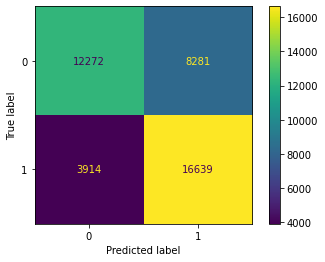

In [ ]:
#Joey: Regression on selected factors. 
#Get relevant columns as data
dataSelectedSubsetData = data[['danceability', 'energy', 'instrumentalness']].values

#Fit model
logm_die = LogisticRegression()
logm_die.fit(X = dataSelectedSubsetData, y = targetData)

#Get coefficients for model. 
print(logm_die.coef_)

#Get accuracy score
predictions = logm_die.predict(dataSelectedSubsetData)
logm_die_accscore = accuracy_score(targetData, predictions)
print(logm_die_accscore)

plot_confusion_matrix(logm_die, dataSelectedSubsetData, targetData)



In [ ]:
#Clone dataset
artistsModData = data.copy()
artistsModData = artistsModData.loc[artistsModData['target'] == 1].reset_index(drop=True)
artistsModData.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,duration_sec,loudness_rounded
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,...,0.706,108.029,188493,4,41.18681,10,1,2010,188.0,-5.0
1,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,...,0.274,172.065,205463,4,44.89147,9,1,2010,205.0,-7.0
2,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,...,0.780,160.517,144244,4,24.99199,8,1,2010,144.0,-4.0
3,Here's To Never Growing Up,Avril Lavigne,spotify:track:0qwcGscxUHGZTgq0zcaqk1,0.482,0.873,0,-3.145,1,0.0853,0.01110,...,0.737,165.084,214320,4,32.17301,12,1,2010,214.0,-3.0
4,Helluva Night,Ludacris,spotify:track:0flKDWZq11997Fb2ptkQvu,0.736,0.522,2,-8.020,1,0.1160,0.02990,...,0.369,97.547,200387,4,60.21027,10,1,2010,200.0,-8.0


In [ ]:
# One-hit wonders versus Staying Power

#Cleaning data
artistsModData['artist'] = artistsModData['artist'].str.replace(r"\(.*\)","")
artistsModData.head()

for i in range(len(artistsModData)):
    artistsModData['artist'][i] = re.split(" [fF][eE][aA][tT]", artistsModData['artist'][i])[0]

# Count Data
artistsCountData = artistsModData.groupby('artist').count().sort_values(by = 'uri' ,ascending=False)
artistsCountData = artistsCountData["track"].reset_index()
artistsCountData = artistsCountData.rename(columns = {'track' : 'counts'})


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
# Get percentiles
#https://www.datasciencemadesimple.com/percentile-rank-column-pandas-python-2/

#Explore
three_or_less = artistsCountData['counts'].quantile(.65912)
print(three_or_less)
print(artistsCountData['counts'].mean())

#Make percentile column
artistsCountData['percentile'] = artistsCountData['counts'].rank(pct=True)

#Is Consistent Hitter Versus One Time Hitter
artistsCountData['one_timer'] = (artistsCountData['percentile'] < .65912).astype(int)

merger = artistsCountData[['artist', 'one_timer']]

print(merger.columns)

3.0
3.751916757940854
Index(['artist', 'one_timer'], dtype='object')


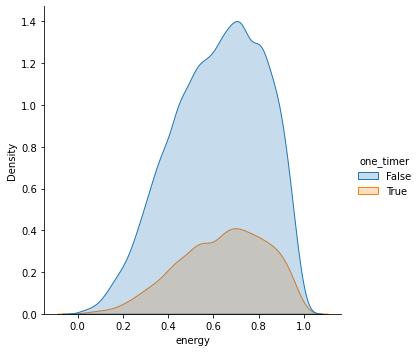

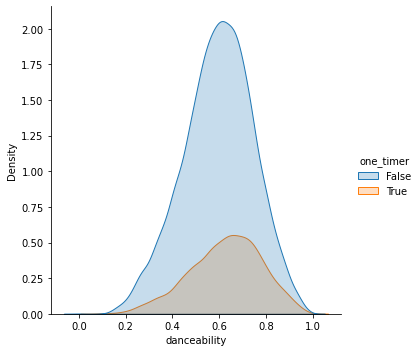

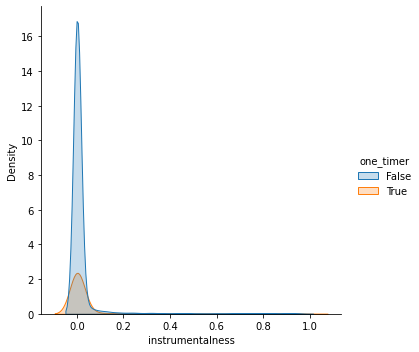

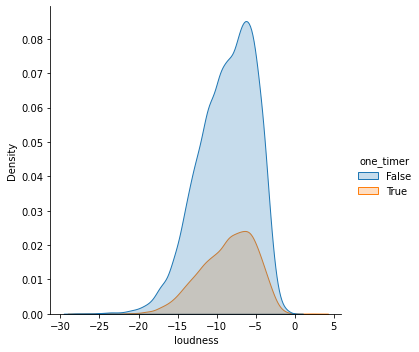

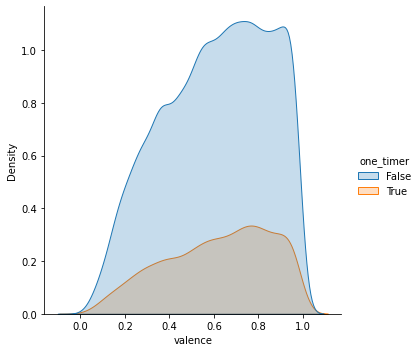

In [ ]:
# Merge with hits 
#to analyze difference in hits between 3 or less timers and consistent hitters

artistsModDataR = pd.merge(merger, artistsModData, on = "artist", how = 'inner')

artistsModDataR['one_timer'] = artistsModDataR['one_timer'].astype('bool')
sns.displot(artistsModDataR , x="energy", hue="one_timer", kind="kde", fill=True)
sns.displot(artistsModDataR , x="danceability", hue="one_timer", kind="kde", fill=True)
sns.displot(artistsModDataR , x="instrumentalness", hue="one_timer", kind="kde", fill=True)
# Non picked factors: 
sns.displot(artistsModDataR , x="loudness", hue="one_timer", kind="kde", fill=True)
sns.displot(artistsModDataR , x="valence", hue="one_timer", kind="kde", fill=True)


In [ ]:
# Regression for each component

# loudness 
loud_data = data[['loudness']].values
lr_loud = LogisticRegression()
lr_loud.fit(X = loud_data, y = targetData)
loud_predict = lr_loud.predict(loud_data)
loud_mse = mean_squared_error(targetData, loud_predict)
loud_r2 = r2_score(targetData, loud_predict)
print("Loudness MSE:", loud_mse, "Loudness r^2:", loud_r2)

# energy 
energy_data = data[['energy']].values
lr_energy = LogisticRegression()
lr_energy.fit(X = energy_data, y = targetData)
energy_predict = lr_energy.predict(energy_data)
energy_mse = mean_squared_error(targetData, energy_predict)
energy_r2 = r2_score(targetData, energy_predict)
print("energy MSE:", energy_mse, "energy r^2:", energy_r2)

# speechiness 
speechiness_data = data[['speechiness']].values
lr_speechiness = LogisticRegression()
lr_speechiness.fit(X = speechiness_data, y = targetData)
speechiness_predict = lr_speechiness.predict(speechiness_data)
speechiness_mse = mean_squared_error(targetData, speechiness_predict)
speechiness_r2 = r2_score(targetData, speechiness_predict)
print("speechiness MSE:", speechiness_mse, "speechiness r^2:", speechiness_r2)

# danceability
danceability_data = data[['danceability']].values
lr_danceability = LogisticRegression()
lr_danceability.fit(X = danceability_data, y = targetData)
danceability_predict = lr_danceability.predict(danceability_data)
danceability_mse = mean_squared_error(targetData, danceability_predict)
danceability_r2 = r2_score(targetData, danceability_predict)
print("danceability MSE:", danceability_mse, "danceability r^2:", danceability_r2)

# valence 
valence_data = data[['valence']].values
lr_valence = LogisticRegression()
lr_valence.fit(X = valence_data, y = targetData)
valence_predict = lr_valence.predict(valence_data)
valence_mse = mean_squared_error(targetData, valence_predict)
valence_r2 = r2_score(targetData, valence_predict)
print("valence MSE:", valence_mse, "valence r^2:", valence_r2)

# tempo
tempo_data = data[['tempo']].values
lr_tempo = LogisticRegression()
lr_tempo.fit(X = tempo_data, y = targetData)
tempo_predict = lr_tempo.predict(tempo_data)
tempo_mse = mean_squared_error(targetData, tempo_predict)
tempo_r2 = r2_score(targetData, tempo_predict)
print("tempo MSE:", tempo_mse, "tempo r^2:", tempo_r2)

# instrumental
instrumentalness_data = data[['instrumentalness']].values
lr_instrumentalness = LogisticRegression()
lr_instrumentalness.fit(X = instrumentalness_data, y = targetData)
instrumentalness_predict = lr_instrumentalness.predict(instrumentalness_data)
instrumentalness_mse = mean_squared_error(targetData, instrumentalness_predict)
instrumentalness_r2 = r2_score(targetData, instrumentalness_predict)
print("instrumentalness MSE:", instrumentalness_mse, "instrumentalness r^2:", instrumentalness_r2)

# duration
duration_data = data[['duration_ms']].values
lr_duration = LogisticRegression()
lr_duration.fit(X = duration_data, y = targetData)
duration_predict = lr_duration.predict(duration_data)
duration_mse = mean_squared_error(targetData, duration_predict)
duration_r2 = r2_score(targetData, duration_predict)
print("duration MSE:", duration_mse, "duration r^2:", duration_r2)

Loudness MSE: 0.3973142606918698 Loudness r^2: -0.5892570427674793
energy MSE: 0.42645842456089134 energy r^2: -0.7058336982435653
speechiness MSE: 0.4773512382620542 speechiness r^2: -0.9094049530482169
danceability MSE: 0.3545224541429475 danceability r^2: -0.4180898165717899
valence MSE: 0.4014985646864205 valence r^2: -0.6059942587456819
tempo MSE: 0.48513598987982287 tempo r^2: -0.9405439595192915
instrumentalness MSE: 0.32885710115311634 instrumentalness r^2: -0.31542840461246535
duration MSE: 0.5 duration r^2: -1.0


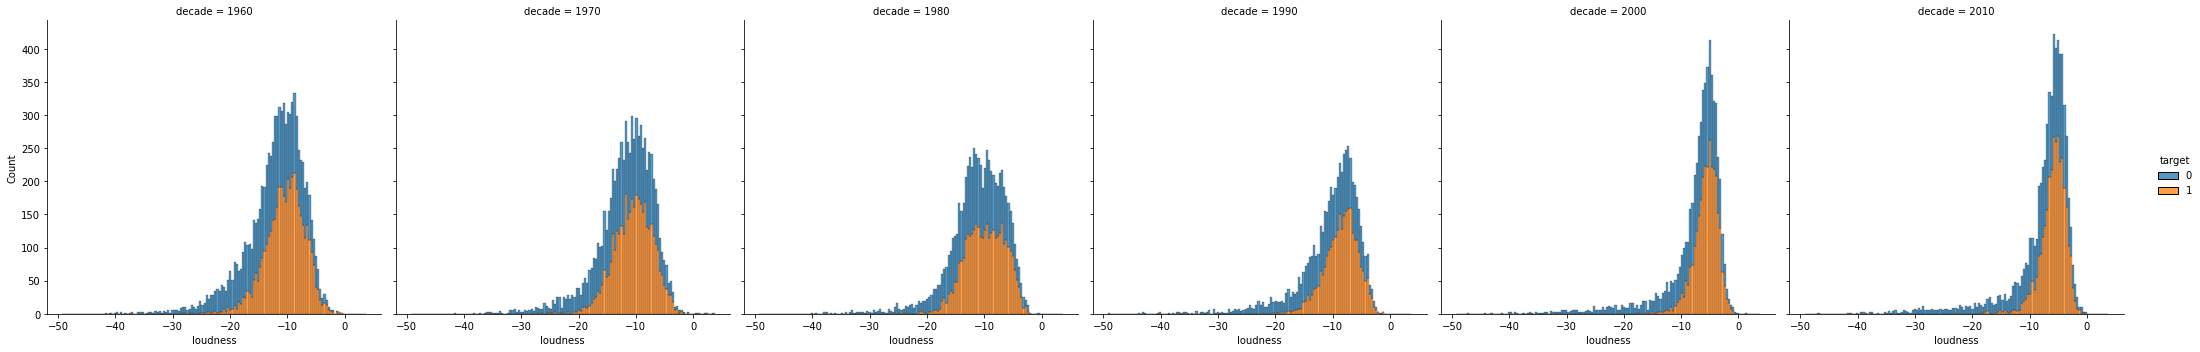

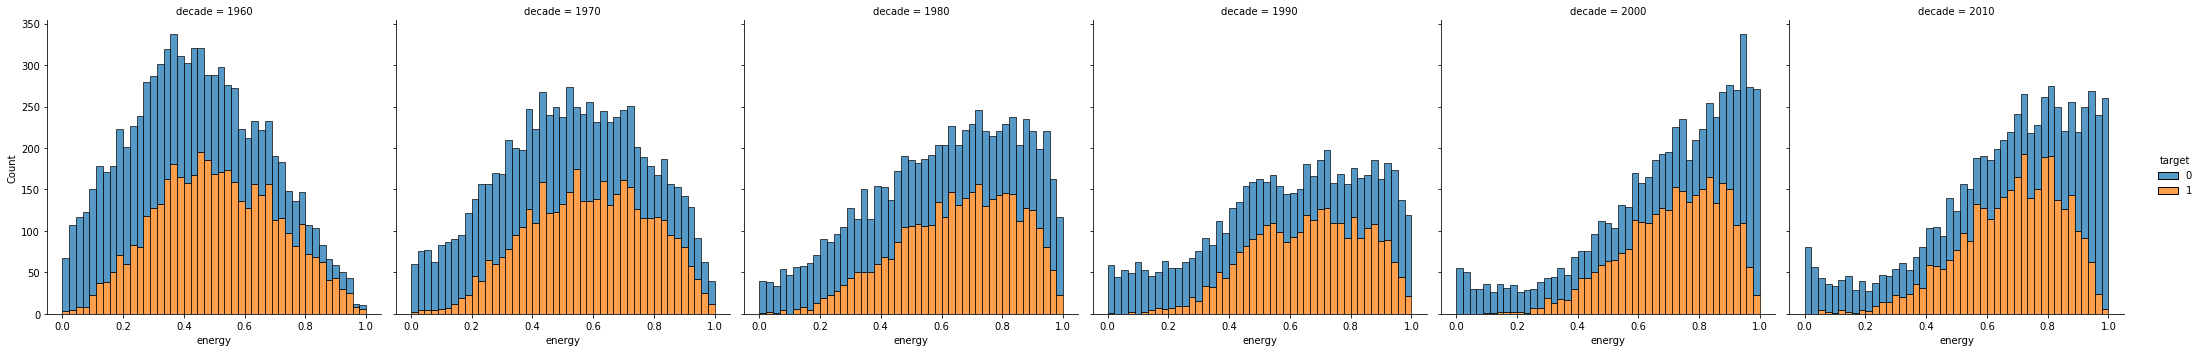

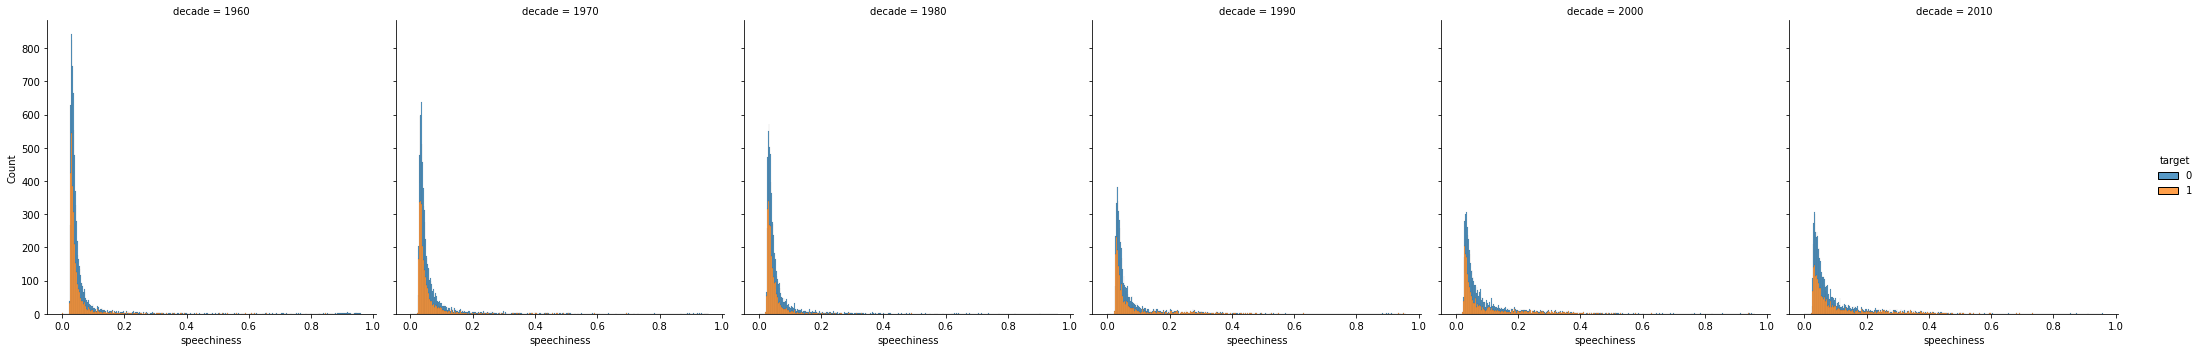

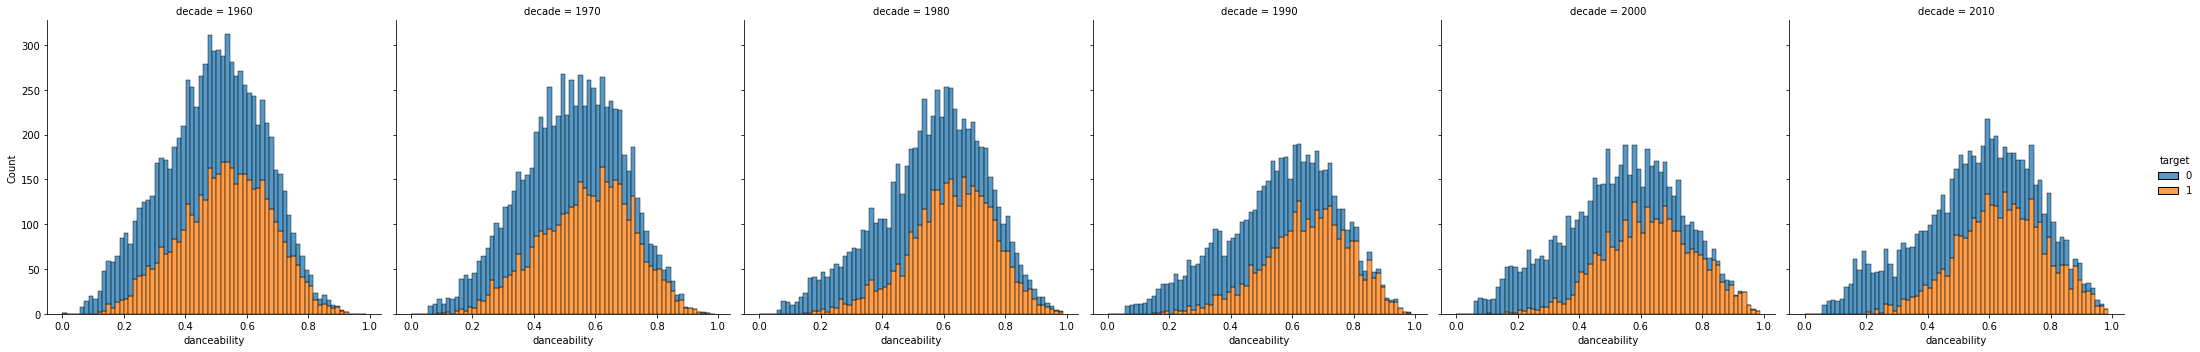

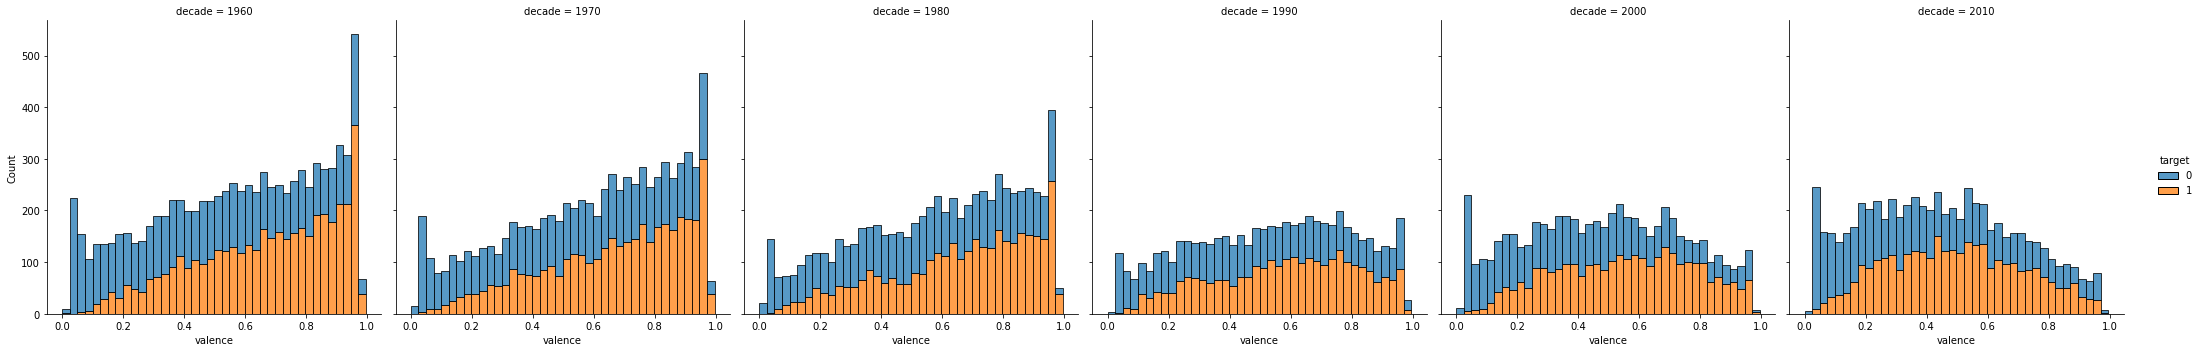

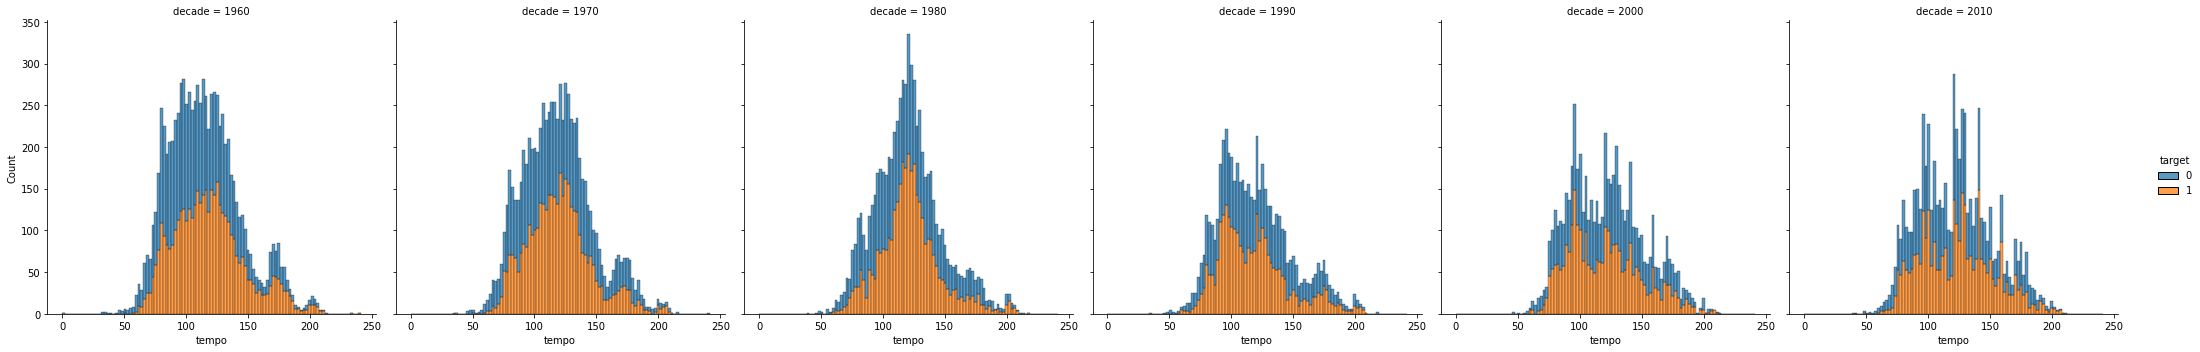

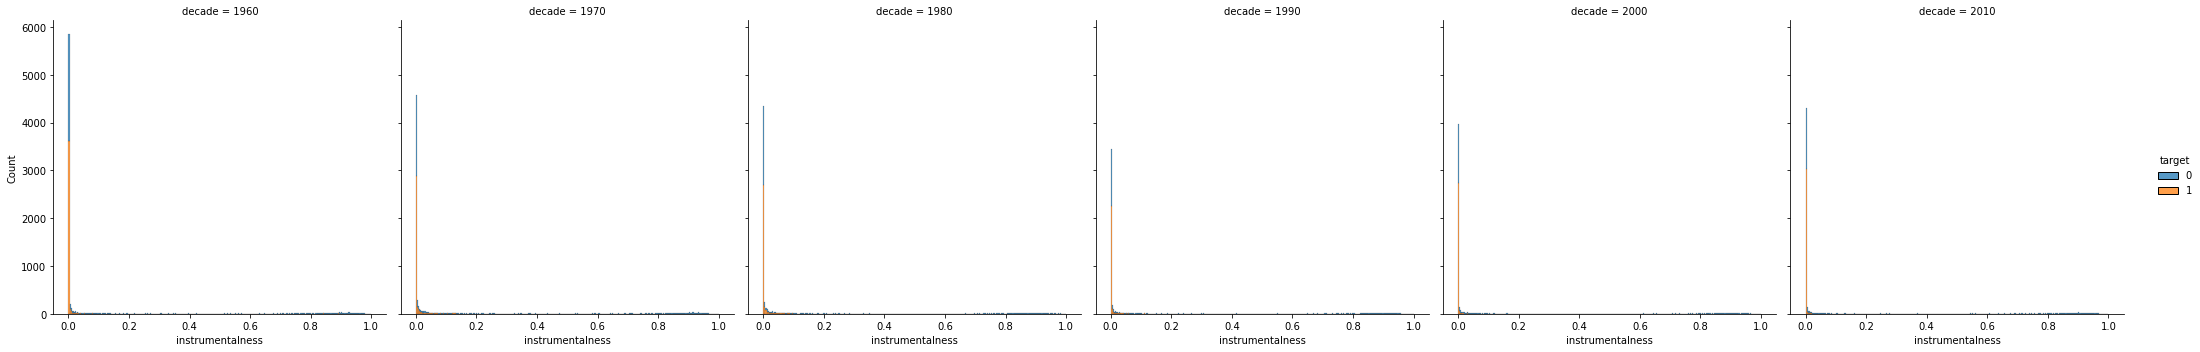

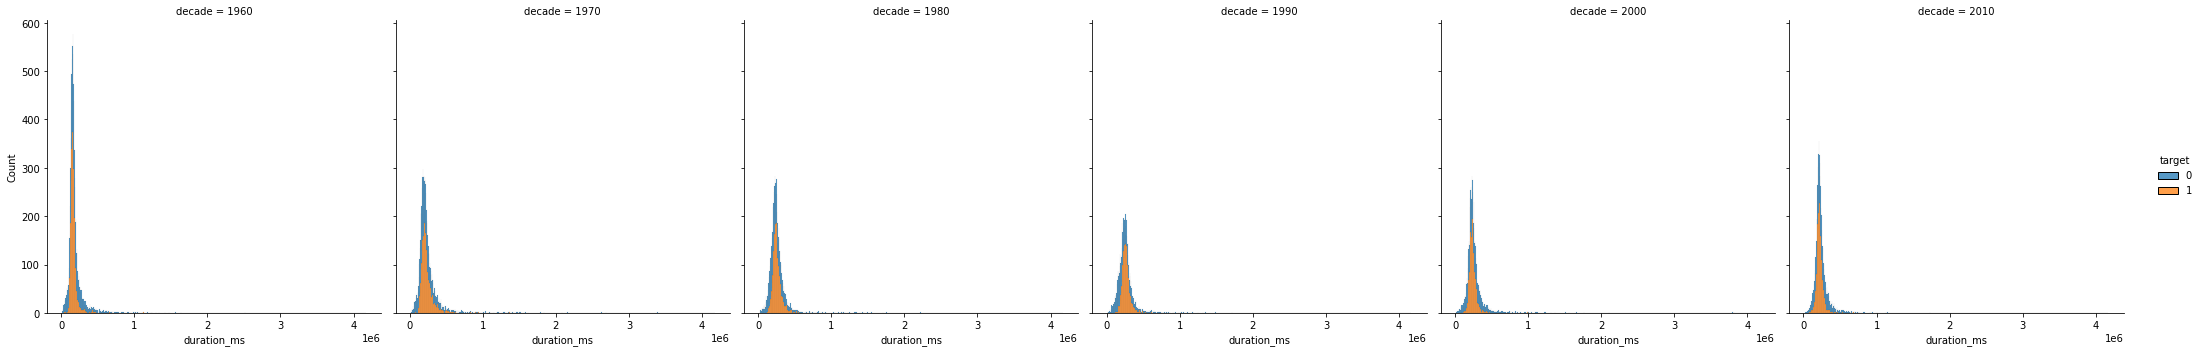

In [ ]:
# Bar plot for each decade which shows the proportion of hits vs flops predicted by each component
# Number of bins needs to be adjusted
# Loudness
sns.displot(data, x="loudness", hue="target", col="decade", multiple="stack")

# energy
sns.displot(data, x="energy", hue="target", col="decade", multiple="stack")

# speechiness
sns.displot(data, x="speechiness", hue="target", col="decade", multiple="stack")

# danceability
sns.displot(data, x="danceability", hue="target", col="decade", multiple="stack")

# valence 
sns.displot(data, x="valence", hue="target", col="decade", multiple="stack")

# tempo
sns.displot(data, x="tempo", hue="target", col="decade", multiple="stack")

# instrumentalness
sns.displot(data, x="instrumentalness", hue="target", col="decade", multiple="stack")

# duration 
sns.displot(data, x="duration_ms", hue="target", col="decade", multiple="stack")

In [ ]:
data.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target', 'decade', 'duration_sec', 'loudness_rounded'],
      dtype='object')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=162d76af-48a2-4f75-9aef-34643a48aa39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>